# Projekt Machine Learning – Online Retail II

Celem projektu jest zbudowanie modelu regresyjnego przewidującego **wartość faktury (InvoiceTotal)** na podstawie danych transakcyjnych Online Retail II z lat 2009–2011.

Pipeline projektu:
1. Wczytanie danych
2. Analiza eksploracyjna danych (EDA)
3. Przygotowanie danych
4. Modelowanie
6. Interpretacja modelu
7. Podsumowanie

## 1. Wczytanie danych

Dane pobrano przy użyciu `load_df_from_kaggle()`, a następnie obliczono kolumnę `TotalPrice`.

W tej sekcji sprawdzono:
- liczbę wierszy,
- brakujące wartości,
- typy danych,
- rozkład podstawowych zmiennych.


Dane pochodzą z publicznego zbioru Online Retail II, który zawiera szczegółowe informacje o transakcjach dokonanych w internetowym sklepie sprzedającym artykuły
dekoracyjne i prezenty. Zbiór obejmuje okres od 01.12.2009 do 09.12.2011 i zawiera ponad 1 milion rekordów.

Każdy wiersz odpowiada pojedynczej pozycji na fakturze (produkt, ilość, cena, klient, kraj, data).
W projekcie dane są agregowane do poziomu całej faktury, aby przewidywać jej łączną wartość (`InvoiceTotal`).

In [2]:
from src.Online_Retail_II.constants import (COL_QUANTITY, COL_UNIT_PRICE, COL_INVOICE_TOTAL, COL_INVOICE_DATE,
                                            COL_TOTAL_PRICE, COL_AVG_UNIT_PRICE, COL_NUM_ITEMS,
                                            COL_NUM_LINES)
from src.Online_Retail_II.data import load_df_from_kaggle
from src.Online_Retail_II.features import prepare_ml_dataset
from src.Online_Retail_II.models import (
    benchmark_model,
    linear_regression_model,
    random_forest_baseline,
    random_forest_optuna,
    xgboost_baseline
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

import shap
from src.Online_Retail_II.interpretation import (
    plot_feature_importances,
    permutation_importance_plot,
    lasso_feature_selection,
    shap_summary
)

In [3]:
df = load_df_from_kaggle(max_rows=10000000)
#df = Or2.load_local()
df[COL_TOTAL_PRICE] = df[COL_QUANTITY] * df[COL_UNIT_PRICE]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   TotalPrice   1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 73.3+ MB


### 1.1 Brakujące dane

Sprawdzono brakujące wartości, aby zdecydować:
- które kolumny trzeba wypełnić (np. CustomerID jeśli decyzja, że traktujemy brak jako niezalogowany klient),
- które można usunąć  (np. Description).

In [4]:
df.isna().sum().sort_values(ascending=False)

Customer ID    243007
Description      4382
Invoice             0
Quantity            0
StockCode           0
InvoiceDate         0
Price               0
Country             0
TotalPrice          0
dtype: int64

## 2. Analiza eksploracyjna danych (EDA)

W tej części poddano analizie rozkłady kluczowych zmiennych, aby:
- wykryć wartości odstające (outliery),
- ocenić normalność / skośność,
- zrozumieć strukturę faktur,
- sprawdzić sezonowość i rozkład czasowy transakcji.

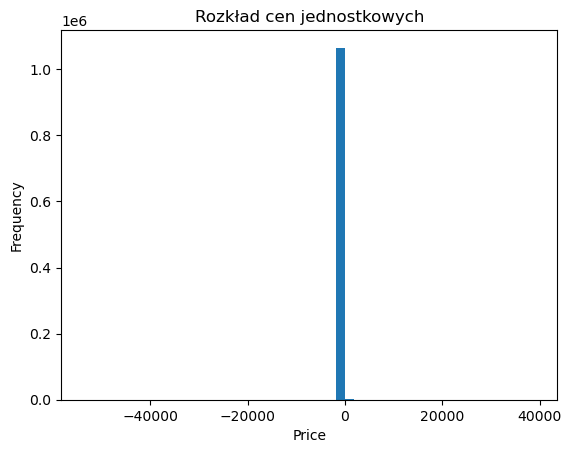

In [5]:
plt.figure()
df[COL_UNIT_PRICE].plot.hist(bins=50)
plt.title("Rozkład cen jednostkowych")
plt.xlabel(COL_UNIT_PRICE)
plt.show()

### 2.1 Rozkłady kluczowych zmiennych

#### 2.1.1 Histogram Quantity


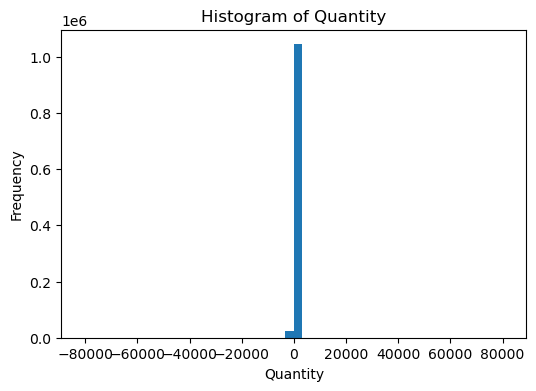

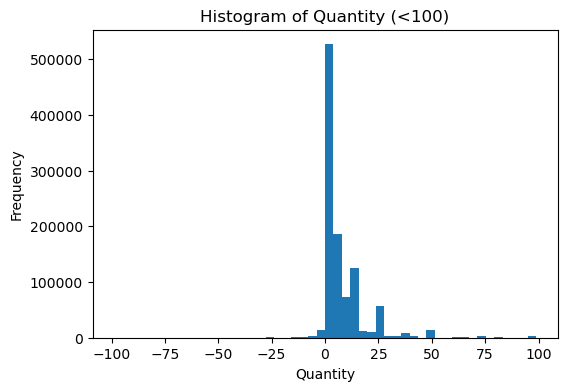

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df[COL_QUANTITY], bins=50)
plt.title("Histogram of Quantity")
plt.xlabel(COL_QUANTITY)
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[(df[COL_QUANTITY] < 100) & (df[COL_QUANTITY] > -100)][COL_QUANTITY], bins=50)
plt.title("Histogram of Quantity (<100)")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()


Histogram dla wszystkich wartości Quantity pokazał zaburzony i nieczytelny wykres - większość danych "ściśnięta" przy osi X. Rozciągnięcie osi X do ok. 80 000 wynika  z występowania outlierów. Taki kształt histogramu wskazuje na pojedyńcze masowe transakcje magazynowe lub błędy. W celu uzyskania realnego obrazu typowych zamówień, został wykonany drugi histogram, w którym zostały uwzględnione jedynie rekordy z Quantity < 100. Dzięki temu, widać że większość transakcji obejmuje bardzo małe ilości produktów (najczęściej 1-5 sztuk), wykres nie jest zdominowany przez skrajne wartości i można lepiej zrozumieć typowe zachowanie klientów.

2.1.2. Histogram UnitPrice

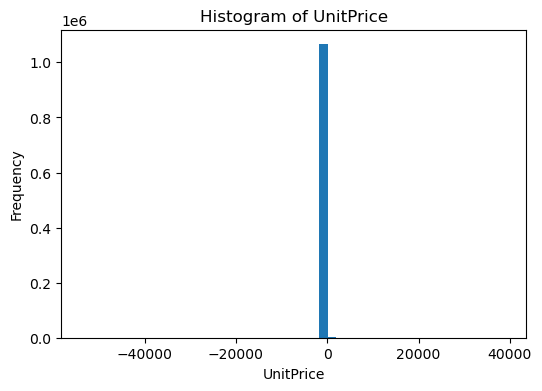

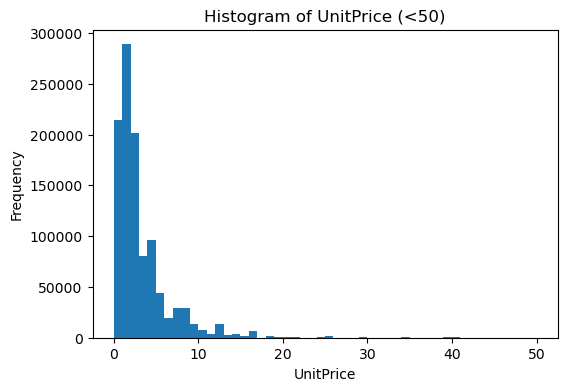

In [7]:

plt.figure(figsize=(6,4))
plt.hist(df[COL_UNIT_PRICE], bins=50)
plt.title("Histogram of UnitPrice")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[(df[COL_UNIT_PRICE] < 50) & (df[COL_UNIT_PRICE] > -50)][COL_UNIT_PRICE], bins=50)
plt.title("Histogram of UnitPrice (<50)")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.show()

Pierwszy histogram wykonany dla wszystkich wartości UnitPrice też okazał się zdeformowany i mało czytelny, dlatego wykonano drugi dla ceny niższej niż 50 GBP. Co można wywnioskować: występują pojedyńcze bardzo drogie produkty, możliwe błędy danych, większość produktów kosztuje od 1 do 5 GBP, ceny powyżej 10 GBP są rzadkie, a w przedziale 20-50 to pojedyńcze przypadki.

2.1.3. Histogram TotalPrice

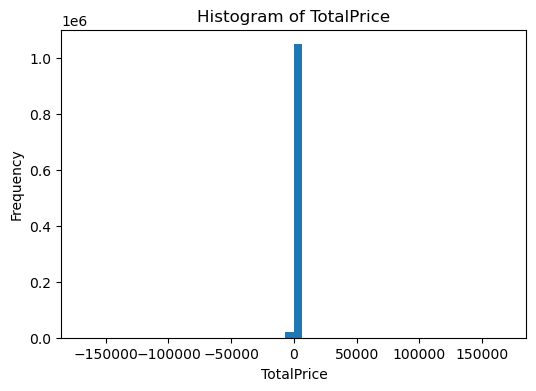

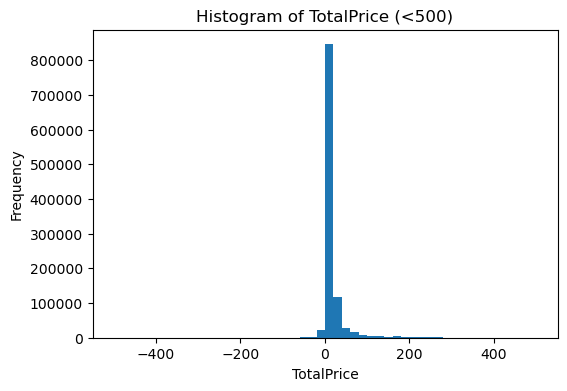

In [8]:
plt.figure(figsize=(6,4))
plt.hist(df[COL_TOTAL_PRICE], bins=50)
plt.title("Histogram of TotalPrice")
plt.xlabel("TotalPrice")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df[(df[COL_TOTAL_PRICE] < 500) & (df[COL_TOTAL_PRICE] > -500)][COL_TOTAL_PRICE], bins=50)
plt.title("Histogram of TotalPrice (<500)")
plt.xlabel("TotalPrice")
plt.ylabel("Frequency")
plt.show()

Histogram `TotalPrice` w pełnym zakresie wartości okazał się całkowicie nieczytelny. Podobnie jak przy `Quantity` i `UnitPrice`, wykres został zdominowany przez pojedyncze, skrajnie wysokie wartości (np. transakcje o wartości ponad 100 000 GBP). Skutkiem tego wszystkie typowe transakcje — o wartościach 1–100 GBP — były niewidoczne przy osi X.

Aby zobaczyć prawdziwy rozkład wartości zamówień, konieczne było ponowne wykonanie histogramu na danych ograniczonych, np. `TotalPrice` < 500. Dopiero taki wykres ujawnia, że większość zamówień ma bardzo niską wartość, a ekstremalnie duże transakcje są rzadkimi outlierami.

2.1.4. Sprzedaż w czasie

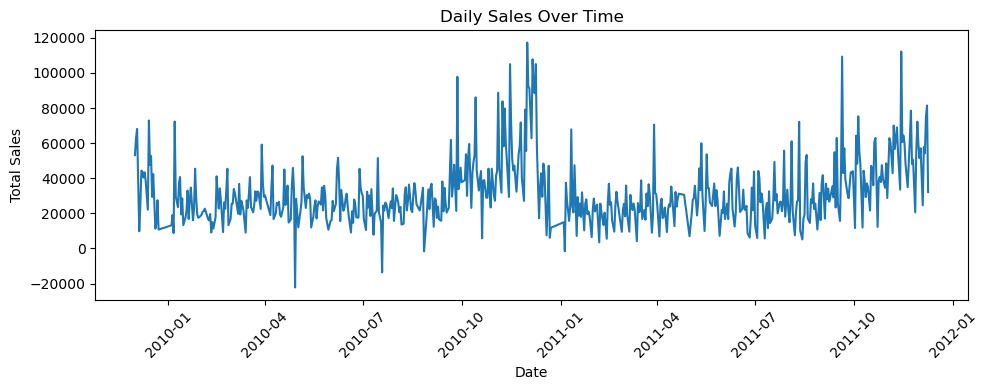

In [9]:
daily_sales = df.groupby(df[COL_INVOICE_DATE].dt.date)[COL_TOTAL_PRICE].sum()

plt.figure(figsize=(10,4))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

W obu latach widoczne są wzrosty sprzedaży w czwartym kwartale, może być to związane z okresem świątecznym. Na wykresie są widoczne pojedyńcze piki, które mogą wynikać z dużych zamówień hurtowych, pojedyńczych zamówieniach o wysokiej wartości, dniach o wyjątkowo dużym ruchu (np. przed świętami, weekendy) lub rzadkich outlierów.

2.1.5 Top kraje

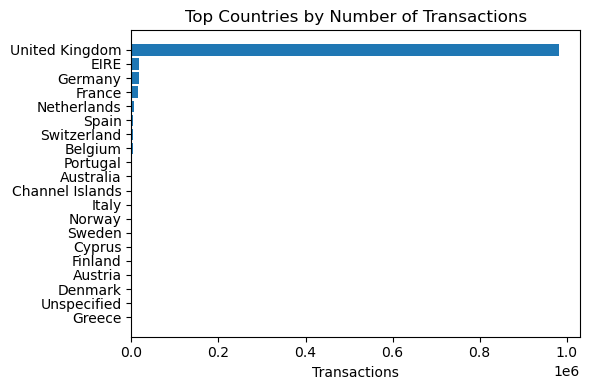

In [10]:
top_countries = df["Country"].value_counts().head(20)

plt.figure(figsize=(6,4))
plt.barh(top_countries.index[::-1], top_countries.values[::-1])
plt.title("Top Countries by Number of Transactions")
plt.xlabel("Transactions")
plt.tight_layout()
plt.show()

2.1.6. Heatmap korelacji

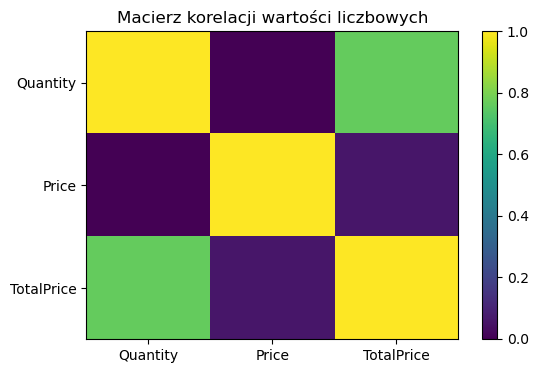

In [11]:
corr = df[[COL_QUANTITY,COL_UNIT_PRICE,COL_TOTAL_PRICE]].corr()

plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xticks(range(3), [COL_QUANTITY,COL_UNIT_PRICE,COL_TOTAL_PRICE])
plt.yticks(range(3), [COL_QUANTITY,COL_UNIT_PRICE,COL_TOTAL_PRICE])
plt.title("Macierz korelacji wartości liczbowych")
plt.show()

Z Heatmap'y korelacji można wywnioskować, że `TotalPrice` jest silnie determinowane przez `Quantiy`. Ma to sens, ponieważ im więcej sztuk jest kupowane tym większa wartość transakcji. `Totalprice` rośnie także, gdy rośnie cena jednostkowa produktu. Nie ma związku między ceną jednostkową, a liczbą sztuk.

## 3. Przygotowanie danych

Na podstawie EDA definiujemy zasady transformacji danych:
- usunięcie faktur anulowanych (`Invoice` zaczynających się od `C`),
- usunięcie pozycji z `Quantity <= 0` lub `UnitPrice <= 0`,
- przefiltrowanie tylko na kraj `United Kingdom`,
- usunięcie kolumn `CustomerID`, `InvoiceDate`,`InvoiceNo`, `Country`
- przycięcie skrajnych wartości faktur (trimming percentylowy).

Sama logika czyszczenia jest zaimplementowana w funkcjach modułu `features.py` (`change_basic_features`, `build_invoice_level_features` oraz `prepare_ml_dataset`).

Z uwagi na bardzo skośny rozkład i obecność ekstremalnych wartości wynikających ze zwrotów lub błędów (co widać na histogramach), zastosowano **trimming percentylowy** (2% najniższych, 2% najwyższych wartości).
Pozwala to usunąć obserwacje, które nie reprezentują realnego pola decyzji modelu, a jedynie zakłócałyby uczenie.
Po obcięciu rozkład staje się bardziej stabilny, a model osiąga niższy błąd generalizacji.

Cechy uzyskane na procesie features engineering. Jeden wiersz określa jedną transakcje / fakturę
- InvoiceTotal - sumarczna kwota
- NumItems - sumaryczna ilość j.m.
- NumLines - liczba pozycji
- AvgUnitPrice - średnia cena jednostkowa
- InvoiceYear - rok
- InvoiceMonth - miesiac roku
- InvoiceDay - dzień miesiąca
- InvoiceHour - godzina
- InvoiceWeekday - dzień tygodnia
- IsWeekend - czy dzień weekendowy

In [12]:
df_ml = prepare_ml_dataset(df)
df_ml.info()
df_ml.head()

<class 'pandas.core.frame.DataFrame'>
Index: 35077 entries, 0 to 36533
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   InvoiceTotal    35077 non-null  float64 
 1   NumItems        35077 non-null  int64   
 2   NumLines        35077 non-null  int64   
 3   AvgUnitPrice    35077 non-null  float64 
 4   InvoiceYear     35077 non-null  category
 5   InvoiceMonth    35077 non-null  category
 6   InvoiceDay      35077 non-null  category
 7   InvoiceHour     35077 non-null  category
 8   InvoiceWeekday  35077 non-null  category
 9   IsWeekend       35077 non-null  bool    
dtypes: bool(1), category(5), float64(2), int64(2)
memory usage: 1.5 MB


,InvoiceTotal,NumItems,NumLines,AvgUnitPrice,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,IsWeekend
0,505.30,166,8,4.081250,2009,12,1,7,1,False
1,145.80,60,4,2.625000,2009,12,1,7,1,False
2,630.33,193,19,3.730526,2009,12,1,9,1,False
3,310.75,145,23,3.628261,2009,12,1,9,1,False
4,2286.24,826,17,2.591176,2009,12,1,9,1,False


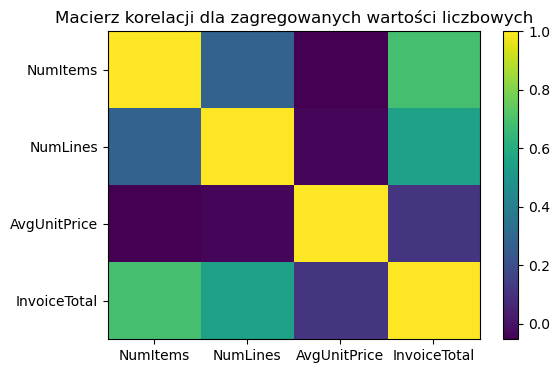

In [13]:
corr = df_ml[[COL_NUM_ITEMS, COL_NUM_LINES, COL_AVG_UNIT_PRICE, COL_INVOICE_TOTAL]].corr()

plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xticks(range(4), [COL_NUM_ITEMS, COL_NUM_LINES, COL_AVG_UNIT_PRICE, COL_INVOICE_TOTAL])
plt.yticks(range(4), [COL_NUM_ITEMS, COL_NUM_LINES, COL_AVG_UNIT_PRICE, COL_INVOICE_TOTAL])
plt.title("Macierz korelacji dla zagregowanych wartości liczbowych")
plt.show()

`InvoiceTotal` zależy głównie od ilości (NumItems, NumLines), a średnia cena jednostki (AvgUnitPrice) gra mniejszą rolę. Modele ML będą prawdopodobnie mocno wykorzystywać cechy ilościowe.

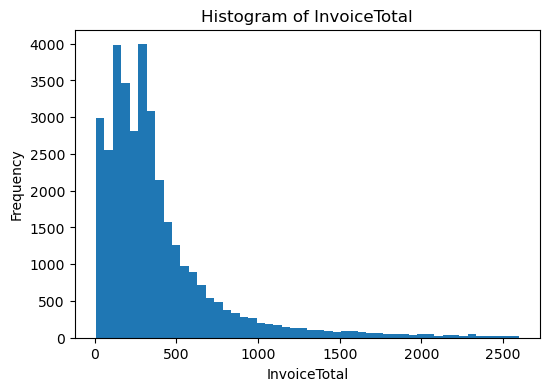

In [14]:
plt.figure(figsize=(6,4))
plt.hist(df_ml[COL_INVOICE_TOTAL], bins=50)
plt.title("Histogram of InvoiceTotal")
plt.xlabel("InvoiceTotal")
plt.ylabel("Frequency")
plt.show()

Rozkład `InvoiceTotal` jest mocno prawo skośny, wystepuje długi ogon. Większość sprzedaży ma niskie wartości (0–600 GBP), natomiast występuje niewielka liczba faktur o bardzo dużych wartościach (2000–4000+ GBP). Większość zakupów jest małych, a duże transakcje są rzadkie.

### 4. Modelowanie
W tej sekcji zbudowano i porównano różne modele przewidujące wartość faktury (InvoiceTotal) na podstawie zagregowanych cech opisujących fakturę (liczba pozycji, liczba sztuk, średnia cena, cechy czasowe). W celu zrozumienia jak dobrze można przewidzieć wartość faktury na podstawie dostępnych danych użyto Benchmarku ze średnią, regresji liniowej, RandomForest baseline, XGBoost oraz RandomForest wspomagany Optuną do wybrania parametrów. Modele porównano pod kątem metryk (MAE, RMSE, R², MAPE).


### 4.1 Benchmark model - średnia
Model ten ignoruje wszystkie cechy i zawsze zwraca średnią wartość faktury z danych treningowych.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df_ml.drop(columns=[COL_INVOICE_TOTAL]),
    df_ml[COL_INVOICE_TOTAL],
    test_size=0.2,
    random_state=42
)

benchmark_metrics = benchmark_model(y_train, y_test)
benchmark_metrics

{'MAE': 245.06343952949342,
 'RMSE': 365.39723329928694,
 'R2': -0.0003954005614827949,
 'MAPE': 234.5482368376904}

### 4.2 Regresja liniowa
model regresji liniowej:
- standardyzuje cechy numeryczne (StandardScaler),
- koduje cechy kategoryczne (OneHotEncoder),
- trenuje model liniowy w pipeline.

In [16]:
pipe_lr, metrics_lr = linear_regression_model(df_ml)
metrics_lr

{'MAE': 136.45258407799665,
 'RMSE': 225.18189183658023,
 'R2': 0.6200660489702573,
 'MAPE': 76.86791802461768}

### 4.3 RandomForest baseline
Model baseline RF:
- działa na danych nieprzeskalowanych,
- nie używa OneHotEncoder,
- wykorzystuje domyślne hiperparametry.

In [17]:
pipe_rf, metrics_rf = random_forest_baseline(df_ml)
metrics_rf

{'MAE': 70.1108062913341,
 'RMSE': 131.3286052214775,
 'R2': 0.8707710425336983,
 'MAPE': 20.070586278161194}

### 4.4 RandomForest + OPTUNA
Automatyczną optymalizację hiperparametrów RandomForest za pomocą biblioteki Optuna.

Optuna stroi m.in.:
- liczbę drzew (n_estimators),
- głębokość drzew (max_depth),
- minimalną liczbę próbek w liściu,
- liczbę cech używanych przy podziale (max_features).

In [18]:
study, best_pipe, best_metrics = random_forest_optuna(df_ml, n_trials=3)
study.best_params

[I 2025-11-28 20:46:12,813] A new study created in memory with name: no-name-a67b99e4-e9ed-4d93-bb8a-479bec5905b9
[I 2025-11-28 20:46:13,439] Trial 0 finished with value: 171.07706335317863 and parameters: {'n_estimators': 396, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 171.07706335317863.
[I 2025-11-28 20:46:14,529] Trial 1 finished with value: 130.37304177446677 and parameters: {'n_estimators': 226, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 1 with value: 130.37304177446677.
[I 2025-11-28 20:46:14,896] Trial 2 finished with value: 172.0669620926422 and parameters: {'n_estimators': 221, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 130.37304177446677.


{'n_estimators': 226,
 'max_depth': 16,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 0.7}

In [19]:
best_metrics

{'MAE': 69.56780524053019,
 'RMSE': 130.37304177446677,
 'R2': 0.8726447731852532,
 'MAPE': 20.239080378431613}

### 4.5 XGBoost baseline
Ostatni model XGBoost, który:
- iteracyjnie buduje kolejne drzewa poprawiające błędy poprzednich,
- radzi sobie świetnie ze skośnymi rozkładami i nieliniowymi zależnościami

In [20]:
pipe_xgb, metrics_xgb = xgboost_baseline(df_ml)
metrics_xgb

{'MAE': 72.05856239535244,
 'RMSE': 137.91171887765577,
 'R2': 0.8574905973107714,
 'MAPE': 22.58351054700249}

### 4.6 Tabelka porównawcza
W tej tabeli zestawiono wyniki wszystkich modeli (Benchmark, LinearRegression, RandomForest baseline, RandomForest po Optunie, XGBoost) na zbiorze testowym.
Porównano metryki (MAE, RMSE, R², MAPE).

Najważniejsze wyniki modeli
- Najlepsze wyniki uzyskał model **RandomForestRegressor z Optuną**, który osiągnął najniższe wartości MAE i RMSE oraz najwyższy współczynnik determinacji R².
- Model liniowy (regresja liniowa) okazał się wyraźnie słabszy, co sugeruje obecność nieliniowych zależności w danych.
- XGBoost daje wyniki porównywalne z RandomForest baseline, ale w tym konkretnym ustawieniu nie przewyższył modelu strojonym Optuną.

In [21]:
results = pd.DataFrame({
    "Benchmark": benchmark_metrics,
    "LinearRegression": metrics_lr,
    "RandomForest": metrics_rf,
    "RF+Optuna": best_metrics,
    "XGBoost": metrics_xgb
}).T

results

,MAE,RMSE,R2,MAPE
Benchmark,245.063440,365.397233,-0.000395,234.548237
LinearRegression,136.452584,225.181892,0.620066,76.867918
RandomForest,70.110806,131.328605,0.870771,20.070586
RF+Optuna,69.567805,130.373042,0.872645,20.239080
XGBoost,72.058562,137.911719,0.857491,22.583511


### 4.7 Uwagi dotyczące cech i standaryzacji

- W przypadku modeli drzewiastych (RandomForest, XGBoost) standaryzacja cech nie jest konieczna – drzewa dobrze działają na surowych skalach.
- Dla modelu liniowego standaryzacja jest kluczowa, dlatego jest wykonywana wewnątrz pipeline’u. Użyto `StandardScaler` oraz `OneHotEncoding`.

## 5. Interpretacja modelu

Poniżej zinterpretowano finalny model (RandomForest z Optuną) za pomocą:
- **feature importance** z modelu,
- **permutation importance**,
- **regresji Lasso** (dla wglądu w zależności liniowe),
- **SHAP**.

Interpretacja modelu pokazała, że największy wpływ na wartość faktury mają:
- **NumItems** – łączna liczba sztuk na fakturze,
- **NumLines** – liczba pozycji (różnych produktów) na fakturze,
- **AvgUnitPrice** – średnia cena jednostkowa produktów,
- oraz w mniejszym stopniu cechy czasowe (miesiąc, dzień tygodnia).

Modele liniowe (Lasso) potwierdziły znaczenie powyższych cech, natomiast SHAP dla modelu drzewiastego dodatkowo ujawnił nieliniowe zależności i interakcje między nimi.

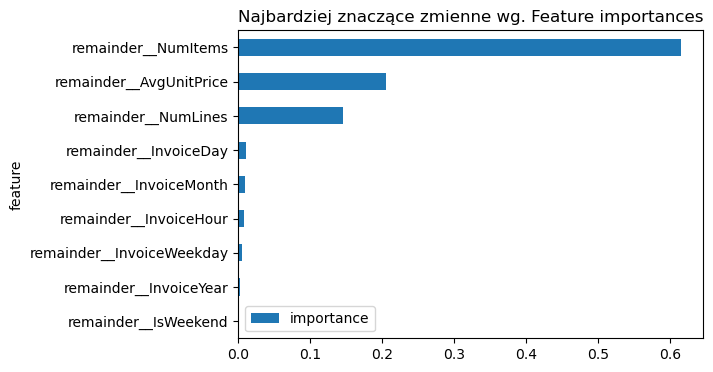

,feature,importance
0,remainder__NumItems,0.615097
2,remainder__AvgUnitPrice,0.204364
1,remainder__NumLines,0.145525
5,remainder__InvoiceDay,0.010223
4,remainder__InvoiceMonth,0.009112
6,remainder__InvoiceHour,0.007288
7,remainder__InvoiceWeekday,0.005395
3,remainder__InvoiceYear,0.002616
8,remainder__IsWeekend,0.000379


In [22]:
plot_feature_importances(best_pipe)

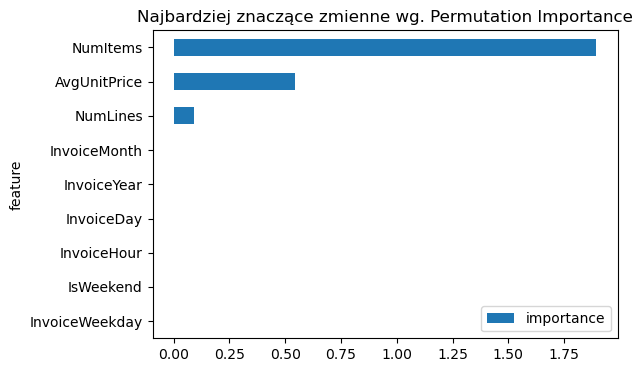

,feature,importance
0,NumItems,1.895102
2,AvgUnitPrice,0.542507
1,NumLines,0.090639
4,InvoiceMonth,0.001214
3,InvoiceYear,0.000376
5,InvoiceDay,0.000167
6,InvoiceHour,0.000047
8,IsWeekend,-0.000032
7,InvoiceWeekday,-0.000101


In [23]:
permutation_importance_plot(best_pipe, X_test, y_test)

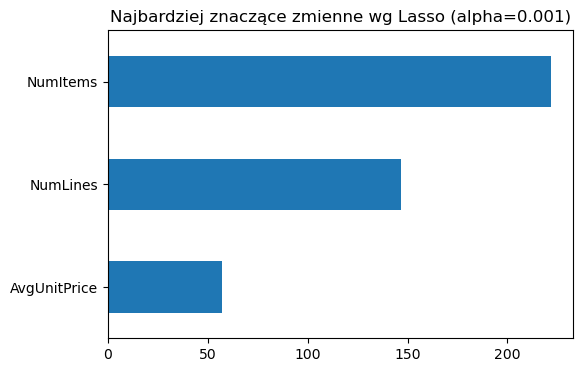

AvgUnitPrice     56.903369
NumLines        146.654686
NumItems        221.684836
dtype: float64

In [24]:
lasso_feature_selection(df_ml)

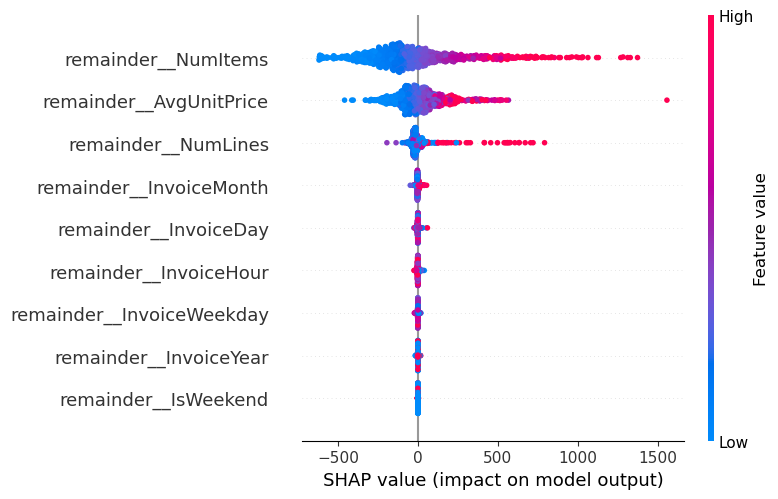

In [25]:
shap.initjs()
shap_summary(best_pipe, X_train)

## 6. Podsumowanie

### 6.1 Najważniejsze wyniki modeli

- Najlepsze wyniki uzyskał model **RandomForestRegressor z Optuną**, który osiągnął najniższe wartości MAE i RMSE oraz najwyższy współczynnik determinacji R².
- Model liniowy (regresja liniowa) okazał się wyraźnie słabszy, co sugeruje obecność nieliniowych zależności w danych.
- XGBoost daje wyniki porównywalne z RandomForest baseline, ale w tym konkretnym ustawieniu nie przewyższył modelu strojonym Optuną.

### 6.2 Wnioski z interpretacji (SHAP, importance, Lasso)

Interpretacja modelu pokazała, że największy wpływ na wartość faktury mają:
- **NumItems** – łączna liczba sztuk na fakturze,
- **NumLines** – liczba pozycji (różnych produktów) na fakturze,
- **AvgUnitPrice** – średnia cena jednostkowa produktów,
- oraz w mniejszym stopniu cechy czasowe (miesiąc, dzień tygodnia).

Modele liniowe (Lasso) potwierdziły znaczenie powyższych cech, natomiast SHAP dla modelu drzewiastego dodatkowo ujawnił nieliniowe zależności i interakcje między nimi.

### 6.3 Możliwe dalsze prace

- Dodanie bardziej zaawansowanych modeli (LightGBM, CatBoost) i porównanie ich z RandomForest.
- Wzbogacenie cech o informacje produktowe (kategorie, grupy asortymentowe).
- Segmentacja klientów (np. RFM, clustering) i budowa osobnych modeli dla różnych segmentów.
- Wydzielenie niezależnego „hold‑out setu” do końcowej walidacji poza Optuną.
